[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://github.com/porterjenkins/byu-cs474/blob/master/lab7_style_transfer.ipynb)

# Style Transfer

In this lab, you will implement the style transfer algorithm proposed by [Gatys et. al. (2016)](https://arxiv.org/pdf/1508.06576.pdf). Your goal is to produce an image that has the high-level content of one image and the low-level style of another.

To perform style transfer, we will use a neural network as a feature extractor to determine style and content features, and we will optimize an image to reach a balance of the chosen style and content. Note that the network does not generate the final image, nor is the network trained at any point in this lab; instead of training network weights, we train the image itself. Through this lab, you will experience another way to use neural networks and see how deep learning can be used to optimize structures other than neural networks.


## Grading standards
Your code will be graded on the following:

* 20% Correct extraction of image statistics
* 35% Correct construction of loss function in a loss class
* 20% Plain English description of equations from (Gatys et. al. 2016) at the bottom of the notebook
* 15% Correct initialization and optimization of image variable
* 10% Awesome looking final image

---

Here's an additional example of style transfer:

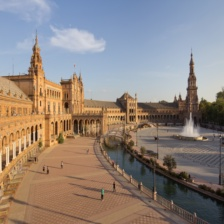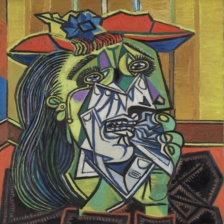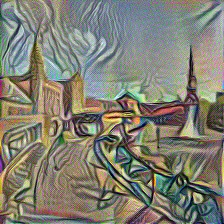

---

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from tqdm import tqdm
from torch.nn.parameter import Parameter
from PIL import Image
import io

# IF NOT USING COLAB: comment out the following import statement:
from google.colab import files

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Select two images: one for content and one for style. The images should have noticeably different content and style from each other to make it clear if the style transfer worked.

In [7]:
# Use this code to upload your own images.
# NOTE: if you are not using Colab, `upload()` will not work. Just make sure the images are on your file system and set `content_path` and `style_path` accordingly.

load_and_normalize = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

def upload():
  print('Upload Content Image')
  file_dict = files.upload()
  content_path = io.BytesIO(file_dict[next(iter(file_dict))])

  print('\nUpload Style Image')
  file_dict = files.upload()
  style_path = io.BytesIO(file_dict[next(iter(file_dict))])
  return content_path, style_path

content_path, style_path = upload()

print("Content Path: {}".format(content_path))
print("Style Path: {}".format(style_path))


Upload Content Image


Saving photo-1477959858617-67f85cf4f1df.jpg to photo-1477959858617-67f85cf4f1df.jpg

Upload Style Image


Saving Man_Ray_Returns_001.webp to Man_Ray_Returns_001 (2).webp
Content Path: <_io.BytesIO object at 0x7ac866ef62a0>
Style Path: <_io.BytesIO object at 0x7ac85ec108b0>


In [8]:
# Load in and normalize the images
content_image_orig = Image.open(content_path)
content_image = load_and_normalize(content_image_orig).unsqueeze(0).to(device)
style_image_orig = Image.open(style_path)
style_image = load_and_normalize(style_image_orig).unsqueeze(0).to(device)


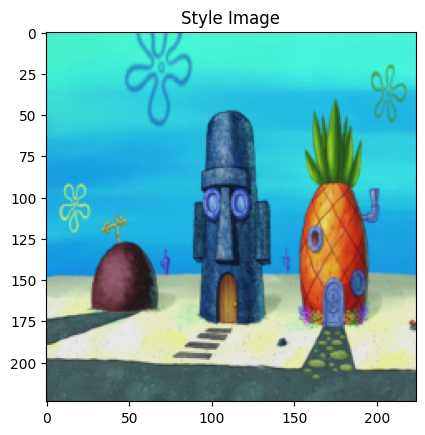

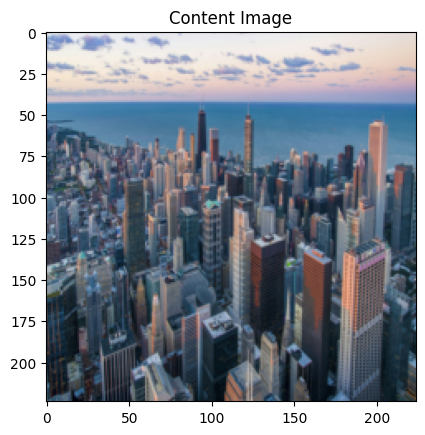

In [9]:
# Display the images
toPIL = transforms.ToPILImage()

def display(tensor, title=None):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = toPIL(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)

plt.figure()
display(style_image, title='Style Image')

plt.figure()
display(content_image, title='Content Image')


___

## Part 1

We will use a pretrained VGG-16 network as a feature extractor to get the style and content statistics from the images.

We provide you with the `VGGIntermediate` class to load in the pretrained model and to grab intermediate layers.



* Correctly initialize a VGGIntermediate object to extract style and content
* Gather content statistics from the outputs of intermediate layers for the content image
* Gather style statistics for the style image

**DONE:**



In [10]:
import torchvision.models as models

# You should not have to change any of the code in the following classes.

# Normalization layer normalizes the image pixels to mean=0 std=1 according to the statistics of the ImageNet training dataset (which the VGG was pretrained on)
class Normalization(nn.Module):
  def __init__(self):
      super(Normalization, self).__init__()
      self.mean = torch.tensor([0.485, 0.456, 0.406]).view(-1, 1, 1).to(device)
      self.std = torch.tensor([0.229, 0.224, 0.225]).view(-1, 1, 1).to(device)

  def forward(self, img):
      return (img - self.mean) / self.std

# Wrapper for the pretrained VGG-16. Instead of returning the output of the VGG, it returns the `requested` layers.
class VGGIntermediate(nn.Module):
  def __init__(self, requested=[]):
    super(VGGIntermediate, self).__init__()
    self.norm = Normalization().eval()
    self.intermediates = {}
    self.vgg = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1).features.eval()
    for i, m in enumerate(self.vgg.children()):
        if isinstance(m, nn.ReLU):   # we want to set the relu layers to NOT do the relu in place.
          m.inplace = False          # the model has a hard time going backwards on the in place functions.

        if i in requested:
          # This stores the output of the requested layer as `intermediates[i]`
          def curry(i):
            def hook(module, input, output):
              self.intermediates[i] = output
            return hook
          m.register_forward_hook(curry(i))

  def forward(self, x):
    self.vgg(self.norm(x))
    return self.intermediates.copy()

We provide you with the list of VGG-16 layer names. Select the names of the layers you'd like to use to extract the content and style ([Gatys et. al. (2016)](https://arxiv.org/pdf/1508.06576.pdf) has suggestions on which layers to use).

Save the layer indexes (not names) into a list for the `requested` parameter of `VGGIntermediate`.

In [11]:
vgg_names = ["conv1_1", "relu1_1", "conv1_2", "relu1_2", "maxpool1", "conv2_1", "relu2_1", "conv2_2", "relu2_2", "maxpool2", "conv3_1", "relu3_1", "conv3_2", "relu3_2", "conv3_3", "relu3_3","maxpool3", "conv4_1", "relu4_1", "conv4_2", "relu4_2", "conv4_3", "relu4_3","maxpool4", "conv5_1", "relu5_1", "conv5_2", "relu5_2", "conv5_3", "relu5_3","maxpool5"]

In [12]:
# (a) conv1_1 and conv2_1
# (b) conv1_1, conv2_1, and conv3_1
# (c) conv1_1, conv2_1, conv3_1, and conv4_1
# (d) conv1_1, conv2_1, conv3_1, conv4_1, and conv5_1

# For simiplicity, I will use the same layers for both content and style images
requested = [vgg_names.index(name) for name in ["conv1_1", "conv2_1", "conv3_1", "conv4_1", "conv5_1"]]
print(requested)

[0, 5, 10, 17, 24]


Create a `VGGIntermediate` object, providing it with the intermediate layers. You can use a single network to extract both the content and the style, but be sure to keep track of which layers are which.

In [13]:
vgg = VGGIntermediate(requested).to(device)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 176MB/s]


Use your `VGGIntermediate` network to extract the content from `content_image` and the style from `style_image`. Save these tensors: they will be used throughout training! Be sure to detach these tensors, since these are our labels and we don't want to backpropagate with respect to them.

In [14]:
content = vgg(content_image)
style = vgg(style_image)

---

## Part 2

The loss functions are key to learning the correct behavior in any machine learning problem. For style transfer, we have two losses: content loss and style loss. Our final loss is a combination of both to provide a balance between these competing objectives.

Show that you understand style transfer by describing the key equations of [Gatys et al. 2016](https://arxiv.org/pdf/1508.06576.pdf) in your own words. You may need to read the surrounding sections to understand the equations.

Content Loss:

- Describe equation (1) on p. 10 of (Gatys 2016) in plain English. Include the meaning of all variables and what each dimension represents for each matrix and vector variable.

$\mathcal{L}_{content}(\vec{p}, \vec{x}, l) = \frac{1}{2}\sum_{i,j} (F^l_{ij} - P^l_{ij})^2$

**Your answer here**:
The content loss aims to minimize the difference between the content of the image the model produced and the original content image.

To understand this formula, I will first explain what each term is. $\overline{p}$ is the original content image (like the image of the city I selected). $\overline{x}$ is a random image which starts as random noise and is gradually updated to make the synthesized image. $l$ denotes the number of the layer from the chosen network.

Furthermore, $F^l$ is the feature representation of the generated image in the $l$th layer. In other words, it is the output of the network in the $l$th layer. This output is an $N_l\times M_l$ matrix where $N_l$ is the number of filters in that layer and $M_l$ is the height times the width of each feature map. So, $F_{ij}^l$ corresponds to the $j$th value of the $i$th filter. The term $P_{ij}^l$ is similar, with the only difference being that it comes from the feature map of the original content image.

Overall, this loss function aims to minimize the difference between the feature maps produced in the $l$th layer from the model that receives the generated image as input and the same model with the content image as input. It takes the difference between each feature, squares it, and sums them all up.

Style Loss:

- Describe equation (3) on p. 11 of (Gatys 2016) in plain English, including the meaning of all variables and what each dimension represents for each matrix and vector variable (including the output).

$G^l_{ij} = \sum_k F^l_{ik} F^l_{jk}$

**Your answer here**:
The goal of this formula is to determine the correlation between filters. This literally is just the inner product between the $i$th and $j$th filters of the feature map in the $l$th layer. As we know from MATH 213, when the inner product is large, the features are correlated, when it is $0$, they are uncorrelated, and when it is largely negative, the features are correlated (but in opposite directions). Overall, for each layer $l$, this gives the gram matrix $G^l$ where the $ij$ entry is the correlation between the $i$th and $j$th filter.


- Describe equation (4) on p. 11 of (Gatys 2016) in plain English, including the meaning of all variables and what each dimension represents for each matrix and vector variable.

$E_l = \frac{1}{4N_l^2M_l^2} \sum_{i,j} (G^l_{ij} - A^l_{ij})^2$

**Your answer here**: In this formula $G^l$ is the Gram matrix from the generated image and $A^l$ is the Gram matrix from the style image (see the explanation above for more information on the Gram matrix). The style loss ($E_l$) at the $l$th layer aimes to minimize the difference between these matrices (by taking the sum of the squares of the difference between each of the entries). Also, as I explained eariler, $N_l$ is the number of filters in the $l$th layer and $M_l$ is the number of elements in each filter map. So, the fraction $\frac{1}{4N_l^2M_l^2}$ is just a scaling term.

To understand this intuitively, the loss is trying to ensure that the correlation between feature maps is consistent from both the generated image and the style image.


- Describe equation (5) on p. 11 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.

$\mathcal{L}_{style}(\vec{a}, \vec{x}) = \sum^L_{l=0} w_lE_l$

**Your answer here**: $\mathcal{L}_{style}(\vec{a}, \vec{x})$ denotes the loss in the model from the style image $\vec{a}$ and the generated image $\vec{x}$. It is a weighted sum of the style losses from each layer ($E_l$). The weights $w_l$ are used to prioritize certain layers over others. For example, for the five layers we chose above, we have $w_l=\frac{1}{5}$ and for all the other layws, we would have $l_w=0$.

___

## Part 3
Now that you understand the loss functions mathematically, create modules that calculate the content and style loss for a single content or style layer.

Since the targets will be static throughout learning (the content and style images don't change, nor the network), we can store them in the loss module objects, so we don't have to pass them into the forward each time.

In [29]:
# Produces a gram matrix from a 4D tensor input
def gram_matrix(F):
    N, C, H, W = F.size()  # Get the size (batch, filters, height, width)
    F = F.view(N * C, H * W)  # Convert to a matrix of correct size
    G = torch.mm(F, F.t())  # Matrix multiplication (dot product for each feature vector)
    return G

# Represents the content loss function for a single content layer
class ContentLoss(nn.Module):
  # Since the targets don't change, store the targets in the init
  def __init__(self, target):
      super().__init__()
      self.target = target

  def forward(self, y_hat):
      self.loss = F.mse_loss(y_hat, self.target, reduction='sum') / 2
      # self.loss = torch.mean((y_hat - self.target))**2 / 2
      return self.loss

# Represents the style loss function for a single style layer
class StyleLoss(nn.Module):
  def __init__(self, target):
      super().__init__()
      self.target = target

  def forward(self, y_hat):
      G = gram_matrix(y_hat)
      A = gram_matrix(self.target)
      N_l, C_l, H_l, W_l = y_hat.size()
      self.loss = F.mse_loss(G, A, reduction='sum')
      # self.loss = torch.mean((G - A))**2
      self.loss = self.loss / (4 * N_l**2 * (H_l*W_l)**2)
      return self.loss

# Instantiate a content loss module for each content layer
#  with the content reference image outputs for that layer for comparison
content_loss_modules = [ContentLoss(content[i]) for i in requested]

# Instantiate a style loss module for each style layer
#  with the style reference image outputs for that layer for comparison
style_loss_modules = [StyleLoss(style[i]) for i in requested]

Now that you have a list of loss modules, write a loss function that computes the combined style transfer loss. You can weight the overall content and style losses, as well as weighting each layerwise loss value.

Return the combined loss as a tensor for learning. Return the content and style loss values for plotting.

In [30]:
def loss(content_features, style_features, y_hat_features, a, b):
    # Calculate the content and stly eloss
    content_loss = ContentLoss(content_features)
    style_loss = StyleLoss(style_features)
    content_loss = content_loss(y_hat_features)
    style_loss = style_loss(y_hat_features)
    # Weighted sum
    combined_loss = a*content_loss + b*style_loss
    return content_loss.item(), style_loss.item(), combined_loss

___

## Part 4
Create and run a method that minimizes the content and style loss for a copy of the content image

Note that the content loss should be zero if you take out the style loss. Why is that?

**TODO:**

* Use an Adam optimizer (try learning rate of .1, but feel free to experiment)
* Show both the content and the style loss every 50 steps
* Ensure that the outputs don't go out of range (clamp them)
* Display the tensor as an image!
* Experiment with different hyperparameters or network layers until you're satisfied with your final image

**DONE:**



First, we need to define our image. While we can create a random image and hope that the optimization works, the best results come from using a clone of the content image. That way, the image starts with the desired content and the content loss only needs to preserve the existing content.

Create a clone of the content image as your initial "generated" image. Calculate and print content and style loss (separately) for your generated image. What do you notice about these losses? Make sure the losses match what you'd expect, given that the generated image is a copy of the content image.

In [31]:
x = content_image.clone()

content_loss, style_loss, combined_loss = loss(content_image, style_image, x, 1, 1)
print("content_loss:", content_loss)
print("style_loss:", style_loss)
print("sombined_loss:", combined_loss.item())

content_loss: 0.0
style_loss: 0.05272214114665985
sombined_loss: 0.05272214114665985


Prepare your generated image for optimization. You need two things:


1.   Your generated image must require gradients: set requires_grad to true by setting the object parameter `requires_grad` or calling the function `requires_grad_()`.
2.   Create an optimizer with your generated image as the parameter. Torch optimizers expect a list of parameters (or tensors), so you'll need to wrap your generated image in a single-item list for the optimizer.



In [21]:
# Prepare your generated image to learn
x = x.requires_grad_(True).to(device)

# Create your optimizer: we suggest starting using an Adam optimizer with lr=.1
optimizer = optim.Adam([x], lr=.1)

Now create and run your training loop, storing content and style losses as you train. Remember, you will be optimizing the **generated image** according to the content and style statistics extracted with the network. Print your final image.

For best results, use `torch.clamp(generated_im, 0, 1)` to keep your pixel values in range after each learning step.

Style transfer is very susceptible to overtraining, which introduces a lot of noise to the final image. Print your image often during the training process to find the best-looking image.

In [28]:
# Reset the variables
x = content_image.clone()
x = x.requires_grad_(True).to(device)
optimizer = optim.Adam([x], lr=0.1)

# Set up the model
num_epochs = 100
content_losses = []
style_losses = []
combined_losses = []
print_image_every = 10


vgg_model = VGGIntermediate(requested=requested).to(device)
# Extract features from the style and content images
content_features = vgg_model(content_image)
style_features = vgg_model(style_image)


for epoch in range(0, num_epochs + 1):
    optimizer.zero_grad()

    # Extract features from the current generated image
    y_hat_features = vgg_model(x)

    # Compute content and style losses
    content_loss_tot = 0.0
    style_loss_tot = 0.0
    combined_loss_tot = torch.tensor(0.0, device=device)  # Keep on the right device

    # Calculate the loss
    for i in requested:
        content_loss, style_loss, combined_loss = loss(content_features[i], style_features[i], y_hat_features[i], 1, 1)
        content_loss_tot += content_loss  # Convert to Python float
        style_loss_tot += style_loss      # Convert to Python float
        combined_loss_tot += combined_loss # Convert to Python float
    # Equally weight each layer
    content_loss_tot = content_loss_tot / len(requested)
    style_loss_tot = style_loss_tot / len(requested)
    combined_loss_tot = combined_loss_tot / len(requested)

    # Store the losses
    content_losses.append(content_loss_tot)
    style_losses.append(style_loss_tot)
    combined_losses.append(combined_loss_tot.item())

    # Display images
    if epoch % print_image_every == 0:
        print(f'Epoch [{epoch}/{num_epochs}], Content Loss: {content_loss_tot:.4f}, Style Loss: {style_loss_tot:.4f}, Combined Loss: {combined_loss_tot:.4f}')

        # Display the images
        plt.figure(figsize=(16, 4))
        plt.subplot(141)
        plt.axis('off')  # Turn off the axis
        display(style_image, title='Style Image')
        plt.subplot(142)
        plt.axis('off')  # Turn off the axis
        display(content_image, title='Content Image')
        plt.subplot(143)
        plt.axis('off')  # Turn off the axis
        display(x, title="Generated Image")

        # Plot the losses
        plt.subplot(144)
        plt.plot(np.arange(len(content_losses)), content_losses, label='Content Loss')
        plt.plot(np.arange(len(style_losses)), style_losses, label='Style Loss')
        plt.plot(np.arange(len(combined_losses)), combined_losses, label='Combined Loss')
        plt.title("Loss Function")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()

    combined_loss_tot.backward(retain_graph=True)
    optimizer.step()

    # Clamp the image values to [0, 1]
    with torch.no_grad():
        x.clamp_(0, 1)

Output hidden; open in https://colab.research.google.com to view.

Plot your content and style losses. Content loss should start at 0 and increase as style loss decreases. They should both reach an equilibrium.

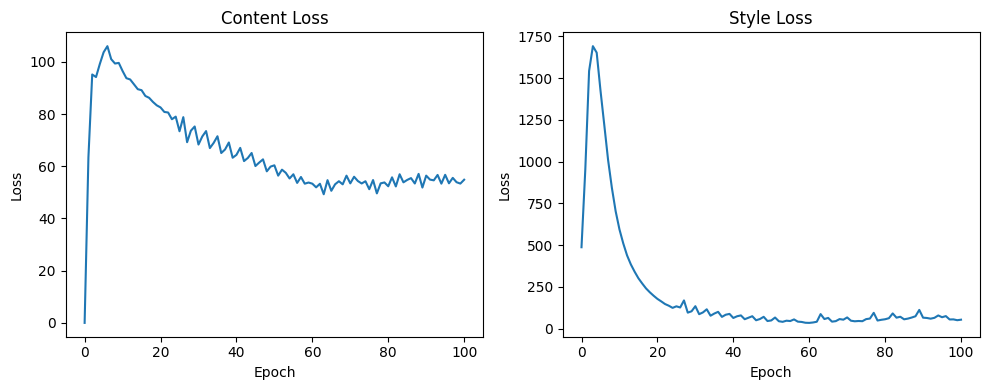

In [ ]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.plot(np.arange(len(content_losses)), content_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Content Loss")

plt.subplot(122)
plt.plot(np.arange(len(style_losses)), style_losses, label='Style Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Style Loss")

plt.tight_layout()
plt.show()

Now that you have style transfer working, the results may not look very appealing. Different content and style images require different hyperparameters, so you should play around with different network layers, learning rates, and loss weighting to get the best results.